# Conditional generative transformer: MNIST demo

Based off https://github.com/GregorKobsik/ImageTransformer

- mnist dataset
    - quantize to 8 values
    - random masking
- model
    - attention mask so that each pixel doesn't get itself as input?
    - predict output distribution for particular pixel
- training
    - learning rate schedule

In [1]:
model_name = input()
print()
new_kernel = True

use_wandb = True
if use_wandb:
    import wandb
    wandb_id = wandb.util.generate_id()

 back-to-small


In [2]:
config = {
    'learning_rate': 0.0025,
    'minibatch_size': 4,
    'test_minibatch_size': 10,
    'n_colors': 8,
    'model': {
        'n_layers': 6,
        'ffl_dim': 128,
        'embd_dim': 64,
        'n_heads': 4,
        'dropout_rate': 0.1,
        'use_idxs_input': True,
    },
    'dataset': {
        'buffer_size': 10000,
        'min_mask': 100,
        'max_mask': 740,
        'square_regions': False,
    },
    'lr_warmup_steps': 1000,
    'lr_schedule': 'warmup_exponential',
    'max_lr': 0.0025,
    'min_lr': 0.00001,
    'batch_size_schedule': 'constant',
    'start_batch_size': 1,
    'end_batch_size': 16,
    'steps_per_epoch': 1000,
    'n_epochs': 30,
    'seq_length': 784,
}

In [3]:
if use_wandb:
    resume = not new_kernel
    wandb.init(project='cgt-mnist', entity='maxeonyx', name=model_name + '-' + wandb_id, config=config, resume=resume)

wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
/am/monterey/home1/clarkemaxw/.cache/pypoetry/virtualenvs/msc-4QRxScII-py3.8/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf
# https://stackoverflow.com/a/60699372/7989988
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten

2021-10-28 09:35:15.571151: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 09:35:16.067591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10421 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:3b:00.0, compute capability: 6.1
2021-10-28 09:35:16.137894: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-28 09:35:16.174661: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached 

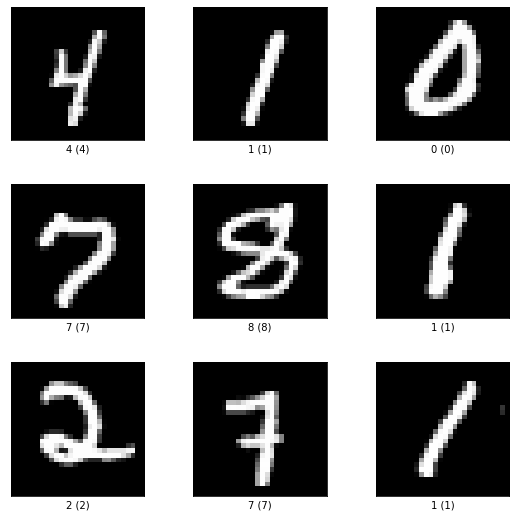

2021-10-28 09:35:16.493081: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


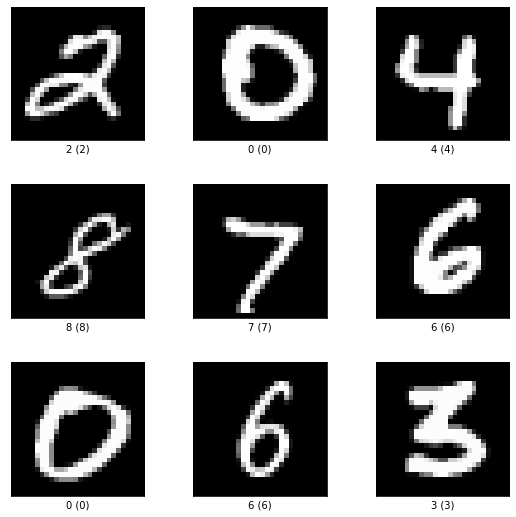

In [5]:
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)

dataset_train_original = dataset['train']
dataset_test_original = dataset['test']

image_width=28
image_height=28

fig = tfds.show_examples(dataset_train_original.take(10), metadata)
fig = tfds.show_examples(dataset_test_original.take(10), metadata)

In [6]:
from sklearn.cluster import MiniBatchKMeans

def normalize_image(image, label):
    return tf.cast(image, dtype=tf.float16) / 255.0, label

def find_centroids(ds_train, num_clusters, batch_size):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size, verbose=True)
    ds_batched = ds_train.batch(batch_size)
    with enlighten.get_manager() as manager:
        title = manager.status_bar(f"K-Means clustering to make {num_clusters}-color MNIST Dataset", justify=enlighten.Justify.CENTER)
        clusters_names = manager.status_bar(''.join('{:<10}'.format(f"cen. {i}") for i in range(num_clusters)))
        clusters_status = manager.status_bar(''.join('{:<10}'.format('??????') for _ in range(num_clusters)))
        pbar = manager.counter(total=60000//batch_size, desc='Discretize to 8 colors', unit='minibatches')
        for img, _ in pbar(iter(ds_batched)):
            pixels = img.numpy().reshape(-1, 1)
            kmeans.partial_fit(pixels)
            clusters_status.update(''.join('{:<10.3f}'.format(x[0]) for x in np.sort(kmeans.cluster_centers_, axis=0)))

        return kmeans.cluster_centers_

centroids = find_centroids(dataset_train_original.map(normalize_image), num_clusters=config['n_colors'], batch_size=1000)
centroids = tf.convert_to_tensor(np.sort(centroids, axis=0), dtype=tf.float16)
print(centroids.shape)

(8, 1)


In [7]:
def squared_euclidean_distance(a, b):
    b = tf.transpose(b)        
    a2 = tf.math.reduce_sum(tf.math.square(a), axis=1, keepdims=True)
    b2 = tf.math.reduce_sum(tf.math.square(b), axis=0, keepdims=True)
    ab = tf.linalg.matmul(a, b)
    return a2 - 2 * ab + b2

def flatten(image, label):
    shape = tf.shape(image) # (height, width, color)
    sequence = tf.reshape(image, (-1, shape[2])) # (height * width, color)
    return sequence, label

def quantize(sequence, label):
    d = squared_euclidean_distance(sequence, centroids) # (height * width, centroids)
    sequence = tf.math.argmin(d, axis=1, output_type=tf.int32)  # (height * width)
    return sequence, label

def unquantize(x):
    x_one_hot = tf.cast(tf.one_hot(x, depth=len(centroids)), dtype=tf.float16)  # (seq, num_centroids)
    return tf.linalg.matmul(x_one_hot,centroids)  # (seq, num_features)

def shuffle_and_add_indices(sequence, label):
    
    idxs = tf.range(config['seq_length'], dtype=tf.int32)
    idxs = tf.random.shuffle(idxs)
    
    sequence = tf.gather(sequence, idxs)
    
    return sequence, idxs, label

def add_indices(sequence, label):
    
    idxs = tf.range(config['seq_length'], dtype=tf.int32)
    
    return sequence, idxs, label

dataset_train = (
    dataset_train_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(shuffle_and_add_indices)
    .cache()
    .repeat()
    .shuffle(config['dataset']['buffer_size'])
    .batch(config['minibatch_size'], drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
dataset_test = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .map(add_indices)
    .cache()
    .batch(config['test_minibatch_size'], drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

unquantized:


2021-10-28 09:35:33.710847: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


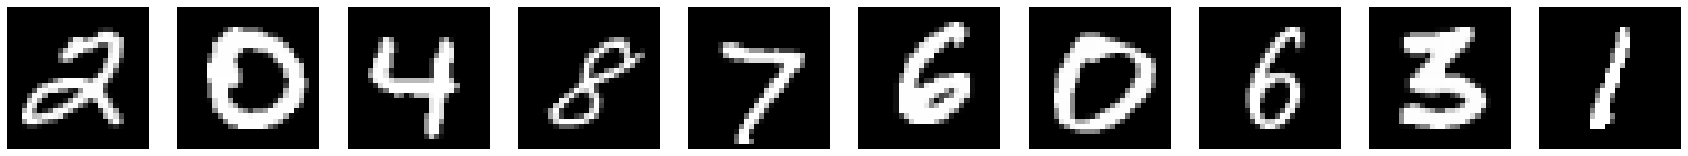

quantized:


2021-10-28 09:35:34.075064: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


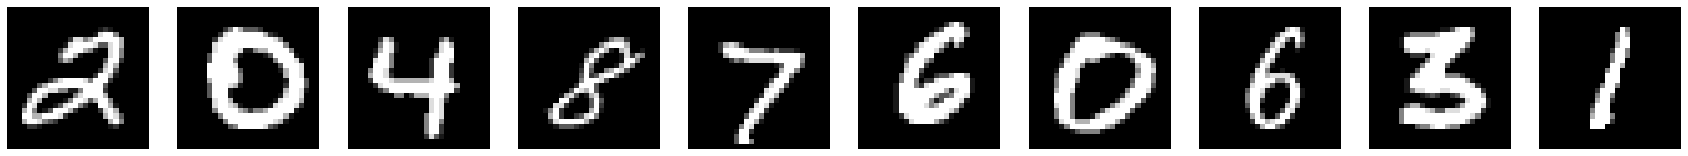

In [8]:
def np_showSeq(seq, size, max_images=3, cmap=None):
    """ Show one or more images encoded as sequence. (numpy version)

        seq: numpy array of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """ 
    batch = seq.shape[0]
    num_show_img = min(max_images, seq.shape[0])
    img = np.reshape(seq, (batch, *size, -1))
    if img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)    
    
    fig=plt.figure(figsize=(3*num_show_img, 3))
    for i in range(num_show_img):
        ax = fig.add_subplot(1, num_show_img, i+1)
        ax.set_axis_off()
        plt.imshow(img[i], cmap=cmap)
    plt.show()

def showSeq(seq, size, max_images=3, cmap='gray', do_unquantize=True):
    """ Show one or more images encoded as sequence. (tensorflow version)

        seq: tensor of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """
    if do_unquantize:
        seq = tf.map_fn(fn=unquantize, elems=seq, fn_output_signature=tf.float16)
    seq = tf.cast(seq, float).numpy()

    np_showSeq(seq, size, max_images, cmap)
    
NUM_SAMPLES = 10

ds_test_unquantized = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .batch(NUM_SAMPLES)
)
ds_test_quantized = (
    dataset_test_original
    .map(normalize_image)
    .map(flatten)
    .map(quantize)
    .batch(NUM_SAMPLES)
)
print("unquantized:")
examples_unquantized, _ = next(iter(ds_test_unquantized))
showSeq(examples_unquantized, (image_width, image_height), NUM_SAMPLES, do_unquantize=False)
print("quantized:")
examples_quantized, _ = next(iter(ds_test_quantized))
showSeq(examples_quantized, (image_width, image_height), NUM_SAMPLES)

In [9]:
def create_look_ahead_mask(size_q, size_k):
    mask = 1 - tf.linalg.band_part(tf.ones((size_q, size_k)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(k, q, v, mask):
    batch_size = tf.shape(k)[0]
    seq_len_kv = tf.shape(k)[-2]
    kq_dim = tf.shape(k)[-1]
    seq_len_q = tf.shape(q)[-2]
    v_dim = tf.shape(v)[-1]
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # shape: (batch_size, n_heads, seq_len_q, seq_len_kv)
    
    dk = tf.cast(kq_dim, tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        mask = create_look_ahead_mask(seq_len_q, seq_len_kv)
        scaled_attention_logits += mask * -1e9 # batch dim broadcast
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # sums to 1 along last axis
    # shape: (batch_size, seq_len_q, seq_len_kv)
    
    output = tf.matmul(attention_weights, v)
    # shape: (batch_size, seq_len_q, v_dim)
    
    return output, attention_weights

def multi_head_attention(embd_dim, n_heads):
    
    wk = layers.Dense(embd_dim)
    wq = layers.Dense(embd_dim)
    wv = layers.Dense(embd_dim)
    dense = layers.Dense(embd_dim)
    
    assert embd_dim % n_heads == 0, "embd_dim must divide evenly into n_heads"
    head_width = embd_dim//n_heads
    
    def split_heads(x, batch_size):
        # reshape from (batch_size, seq_length, embd_dim) to (batch_size, num_heads, seq_len, head_width)
        x = tf.reshape(x, (batch_size, -1, n_heads, head_width))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(k, q, v, mask):
        batch_size = tf.shape(k)[0]
        
        k = wk(k)
        q = wk(q)
        v = wk(v)
        # shape: (batch_size, seq_len_*, embd_dim)
        
        k = split_heads(k, batch_size)
        q = split_heads(q, batch_size)
        v = split_heads(v, batch_size)
        # shape: (batch_size, num_heads, seq_len_*, head_width)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(k, q, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # (batch_size, seq_len, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, embd_dim))
        output = dense(concat_attention)
        return output, attention_weights
    return call
    
def pointwise_feedforward_layer(hidden_dim, out_dim):
    dense1 = layers.Dense(hidden_dim, activation='relu')
    dense2 = layers.Dense(out_dim)
    def call(x):
        x = dense1(x)
        x = dense2(x)
        return x
    return call
        

def transformer(n_colors, seq_length, mask, embd_dim, ffl_dim, n_heads, n_layers, dropout_rate, use_idxs_input):
    def decoder_layer():
        mha = multi_head_attention(embd_dim, n_heads)
        ffl = pointwise_feedforward_layer(ffl_dim, embd_dim)
        layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        dropout1 = layers.Dropout(dropout_rate)
        dropout2 = layers.Dropout(dropout_rate)
        def call(kv_embd, q_embd, mask):
            x = q_embd
            out1 = layernorm1(dropout1(kv_embd)) # prenorm
            attn_out, attn_weights = mha(out1, q_embd, out1, mask)
            x += attn_out
            
            out2 = layernorm2(dropout2(x)) # prenorm
            ffl_out = ffl(out2)
            x += ffl_out
            
            return x
        return call

    def decoder_block():
        color_embedding = layers.Embedding(n_colors, embd_dim)
        position_embedding = layers.Embedding(seq_length, embd_dim)
        # todo: try separate embedding layer for targ
        dec_layers = [decoder_layer() for _ in range(n_layers)]
        dropout = layers.Dropout(dropout_rate)
        layer_norm = layers.LayerNormalization(epsilon=1e-6)
        def call(colors, mask, inp_idxs, tar_idxs):
            batch = tf.shape(colors)[0]
            seq_len = tf.shape(colors)[1]
            
            col_embd = color_embedding(colors)
            
            if use_idxs_input:
                inp_pos_embd = position_embedding(inp_idxs)
                tar_pos_embd = position_embedding(tar_idxs)
            else:
                inp_idxs = tf.expand_dims(tf.range(seq_length), axis=0)
                tar_idxs = tf.expand_dims(tf.range(1, seq_length+1), axis=0)
                inp_pos_embd = tf.tile(position_embedding(inp_idxs), [batch, 1, 1])
                tar_pos_embd = tf.tile(position_embedding(tar_idxs), [batch, 1, 1])
            
            x = col_embd + inp_pos_embd # TODO try: + tar_pos_embd
            x = dec_layers[0](x, tar_pos_embd, mask)
            for i in range(1, n_layers):
                x = dec_layers[i](x, x, mask)
            x = layer_norm(dropout(x))
            return x
        return call
    
    inputs = []
    
    colors = keras.Input([seq_length])
    inputs += [colors]
    
    if use_idxs_input:
        inp_idxs = keras.Input([seq_length])
        inputs += [inp_idxs]
        
        tar_idxs = keras.Input([seq_length])
        inputs += [tar_idxs]
    
        x = decoder_block()(colors, mask, inp_idxs, tar_idxs)
    else:
        x = decoder_block()(colors, mask)
    
    final_layer = layers.Dense(n_colors)(x)
    
    return Model(inputs=inputs, outputs=[final_layer])



In [10]:

model = transformer(
    config['n_colors'],
    seq_length=783,
    mask=True,
    **config['model'],
)
print('Model Config')
print(', '.join(f'{k}: {v}' for k, v in config['model'].items()))
print()

from keras.utils.vis_utils import plot_model

# plot_model(model, to_file="model.png", expand_nested=True, show_shapes=True, show_layer_names=True)


Model Config
n_layers: 6, ffl_dim: 128, embd_dim: 64, n_heads: 4, dropout_rate: 0.1, use_idxs_input: True



In [ ]:

total_steps = config['n_epochs'] * config['steps_per_epoch']

class WarmupInvSquare(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embd_dim, warmup_steps):
        super(WarmupInvSquare, self).__init__()

        self.d_model = embd_dim
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step * (self.warmup_steps ** -1.5)
        arg2 = tf.math.rsqrt(step)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

class WarmupLinear(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, peak_lr, warmup_steps):
        super(WarmupLinear, self).__init__()
        
        self.peak_lr = peak_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step/self.warmup_steps
        arg2 = 1 - (step-self.warmup_steps)/(self.total_steps - self.warmup_steps)
        
        return self.peak_lr * tf.math.minimum(arg1, arg2)

class Constant(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, rate):
        super(Constant, self).__init__()
        self.rate = rate
    
    def __call__(self, step):
        return tf.ones_like(step)*self.rate

class WarmupExponential(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, peak_lr, final_lr):
        super(WarmupExponential, self).__init__()
        self.scale = tf.cast(peak_lr, tf.float64)
        self.rate = tf.cast(total_steps/tf.math.log(peak_lr/final_lr), tf.float64)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float64)
        decay_step = tf.cast(step-self.warmup_steps, tf.float64)
        arg1 = step/self.warmup_steps
        arg2 = tf.math.exp(-decay_step / self.rate)
        return self.scale * tf.math.minimum(arg1, arg2)
    
def exponential_batch_size(initial, final):
    
    scale = tf.cast(initial, tf.float64)
    rate = tf.cast(total_steps/tf.math.log(initial/final), tf.float64)
    
    def call(step):
        step = tf.cast(step, tf.float64)
        return tf.cast(tf.math.floor(scale * tf.math.exp(-step / rate)), dtype=tf.int32)
    return call
                             
def const_batch_size(batch_size):
    def call(step):
        return batch_size*tf.ones_like(step)
    return call
    
lr_schedules = {
    'constant': Constant(0.001),
    'warmup_exponential': WarmupExponential(config['lr_warmup_steps'], config['max_lr'], config['min_lr']),
    'warmup_inv_square': WarmupInvSquare(config['model']['embd_dim'], config['lr_warmup_steps']),
    'warmup_linear': WarmupLinear(config['max_lr'], config['lr_warmup_steps']),
}
batch_size_schedules = {
    'exponential': exponential_batch_size(config['start_batch_size'], config['end_batch_size']),
    'constant': const_batch_size(config['start_batch_size']),
}

fig, axes = plt.subplots(len(lr_schedules), 1, figsize=(20,4*len(lr_schedules)))
fig.suptitle("Learning Rate Schedules")
x = tf.range(0, total_steps, 10, dtype=tf.float32)
for ax, (name, lr_schedule) in zip(axes, lr_schedules.items()):
    ax.set_title(name)
    ax.plot(x, lr_schedule(x))
fig, axes = plt.subplots(len(batch_size_schedules), 1, figsize=(20,4*len(batch_size_schedules)))
fig.suptitle("Batch Size Schedules")
for ax, (name, bs_schedule) in zip(axes, batch_size_schedules.items()):
    ax.set_title(name)
    ax.plot(x, bs_schedule(x))
plt.show()

2021-10-28 09:36:09.713451: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2021-10-28 09:36:09.714853: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


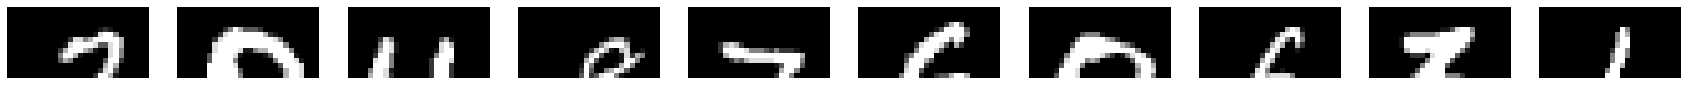

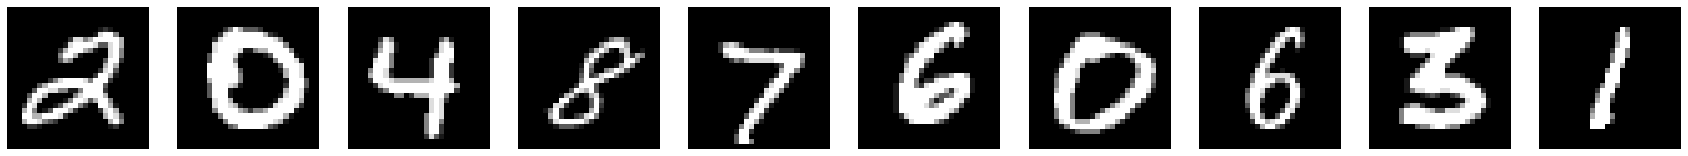

2021-10-28 09:36:10.392714: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:

# params taken from the linked notebook
optimizer = keras.optimizers.Adam(learning_rate=lr_schedules[config['lr_schedule']], beta_1=0.9, beta_2=0.95, epsilon=1e-9)
loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')
bs_schedule = batch_size_schedules[config['batch_size_schedule']]


@tf.function
def train_step_grad_accum(dataset_iterator, accum_steps):
    float_steps = tf.cast(accum_steps, tf.float32)
    accum_gradients = [tf.zeros_like(weights, dtype=tf.float32) for weights in model.trainable_variables]
    accum_loss = tf.constant(0, tf.float32)
    for step in tf.range(accum_steps):
        colors, idxs, labels = next(dataset_iterator)
        loss, gradients = train_step_inner(colors, idxs)
        accum_gradients = [accum_grad+grad for accum_grad, grad in zip(accum_gradients, gradients)]
        accum_loss += loss
    accum_gradients = [accum_grad / float_steps for accum_grad in accum_gradients]
    optimizer.apply_gradients(zip(accum_gradients, model.trainable_variables))
    accum_loss /= float_steps
    return accum_loss
        
@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
])
def train_step_inner(colors, idxs):
    x_inp = colors[:, :-1]
    x_tar = colors[:, 1:]
    i_inp = idxs[:, :-1]
    i_tar = idxs[:, 1:]
    with tf.GradientTape() as tape:
        x_out = model([x_inp, i_inp, i_tar])
        loss = loss_function(x_tar, x_out)
        gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients

@tf.function
def train_step_normal(dataset_iterator):
    colors, idxs, labels = next(dataset_iterator)
    loss, gradients = train_step_inner(colors, idxs)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
])
def eval_step(inp_colors, inp_idxs, tar_idxs):
    return model([inp_colors, inp_idxs, tar_idxs], training=False)

def evaluate(inp_colors, all_idxs, manager=None):
    n = inp_colors.shape[-1]
    n_total = all_idxs.shape[-1]
    out_colors = inp_colors

    if manager is None:
        manager = enlighten.get_manager()
    evaluate_counter = manager.counter(total=n, desc="Evaluating", unit='pixels', leave=False)
    for i in evaluate_counter(range(n, n_total)):
        
        inp_idxs = all_idxs[:, :i]
        tar_idxs = all_idxs[:, 1:i+1]
        
        logits = eval_step(out_colors, inp_idxs, tar_idxs)
        # shape: (batch_size, seq_length, n_colors)
        
        # apply softmax on the logits and return the result
        predictions = tf.random.categorical(logits[:, -1], 1, dtype=tf.int32)
        # append prediction
        out_colors = tf.concat([out_colors, predictions], axis=-1)
    evaluate_counter.close()
    return out_colors

def process_batch(all_colors, all_idxs, show_input=True, show_output=True, manager=None):
    batch_size = all_colors.shape[0]
    n = all_colors.shape[-1] // 2 
    half_colors = all_colors[:, :n]
    if show_input:
        showSeq(half_colors, (image_width//2, image_height), batch_size)
        showSeq(all_colors, (image_width, image_height), batch_size)
    if show_output:
        result_colors = evaluate(half_colors, all_idxs, manager=manager)
        showSeq(result_colors, (image_width, image_height), batch_size)

test_batch_colors, test_batch_idxs, batch_labels = next(iter(dataset_test))
test_batch_colors, test_batch_idxs = test_batch_colors[0:10], test_batch_idxs[0:10]
process_batch(test_batch_colors, test_batch_idxs, show_output=False)

n_epochs, steps_per_epoch = config['n_epochs'], config['steps_per_epoch']
last_eval_loss = None
loss_history = np.zeros([n_epochs*steps_per_epoch])

dataset_iterator = iter(dataset_train)

def train(n_epochs, steps_per_epoch, do_eval):
    global last_eval_loss, loss_history
    window_size = 200

    with enlighten.get_manager() as manager:
        status = manager.status_bar(f"Training model '{model_name}'", justify=enlighten.Justify.CENTER)
        info = manager.status_bar('Loss: ??????, Learning Rate: ???????, Batch Size: ???*?????')
        def update_infobar(loss, learning_rate, minibatch_size, batch_size):
            info.update(f'Loss ({window_size} step avg.): {loss:.5f}, Learning Rate: {learning_rate:.6f}, Batch Size: {minibatch_size:>3}*{batch_size:<5}')
        epochs = manager.counter(total=n_epochs, desc='Epochs', color='green', unit='epochs')
        last_step = 0
        for epoch in epochs(tf.range(n_epochs)):
            steps = manager.counter(total=steps_per_epoch, desc=f'Epoch {epoch:<3}', color='blue', unit='steps')
            for step in steps(tf.range(steps_per_epoch)):
                step_index = epoch*steps_per_epoch + step
                
                accum_steps = bs_schedule(step_index)
                
                loss = train_step_grad_accum(dataset_iterator, accum_steps)
                loss_history[step_index] = loss
                running_mean = np.mean(loss_history[max(0, step_index-window_size) : step_index+1])
                update_infobar(running_mean, optimizer._decayed_lr(tf.float32), config['minibatch_size'], accum_steps)
                if do_eval:
                    if last_eval_loss is None or (running_mean <= last_eval_loss * 0.9 and step_index >= last_step + 30):
                        last_eval_loss = running_mean
                        last_step = step_index
                        print(f"Step {step_index}, Loss ({window_size} step avg.): {last_eval_loss}")
                        process_batch(test_batch_colors, test_batch_idxs, show_input=False, manager=manager)


Step 0, Loss (200 step avg.): 0.6610239148139954


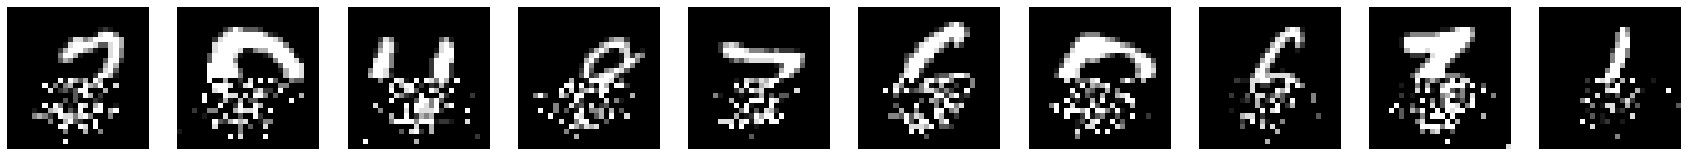

Step 30, Loss (200 step avg.): 0.5896400338219058


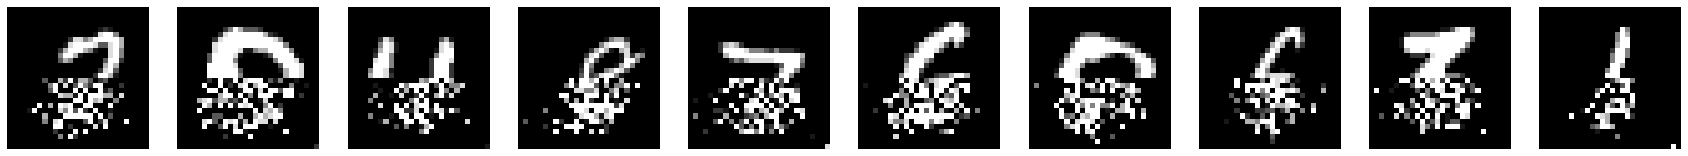

Step 936, Loss (200 step avg.): 0.5301044805726008


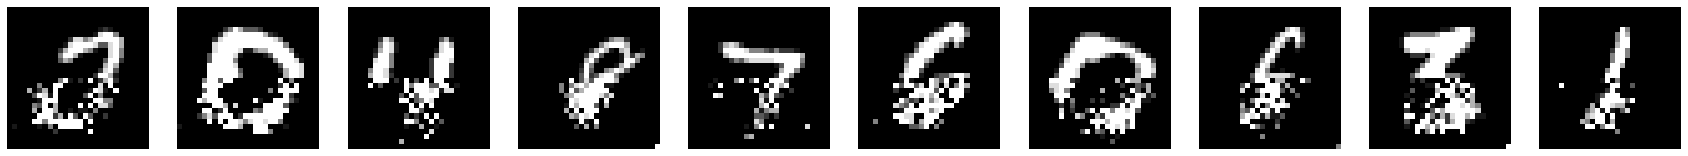

Step 1044, Loss (200 step avg.): 0.4769453057898811


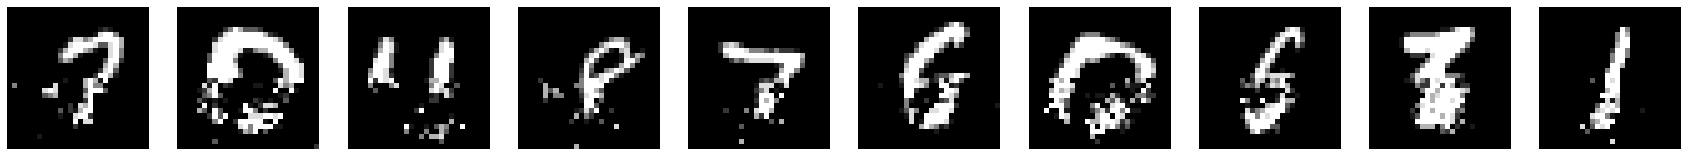

Step 1138, Loss (200 step avg.): 0.42898572128803575


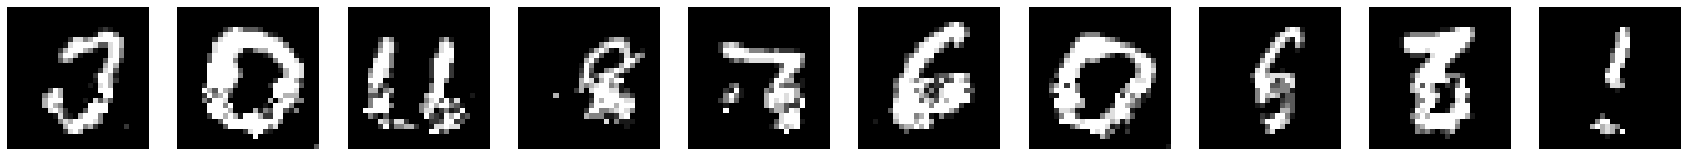

Step 1255, Loss (200 step avg.): 0.38596030076344806


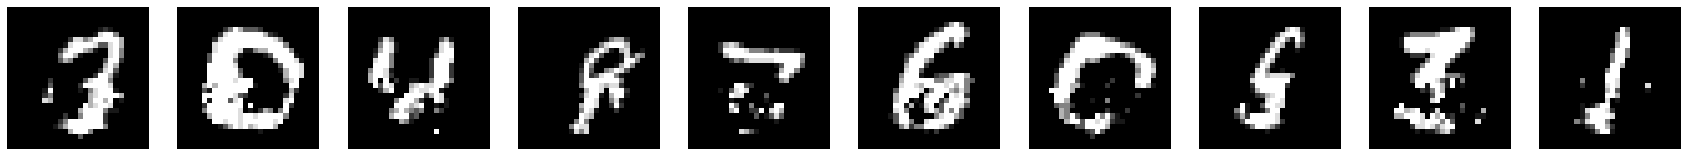

Step 1881, Loss (200 step avg.): 0.3471368480825899


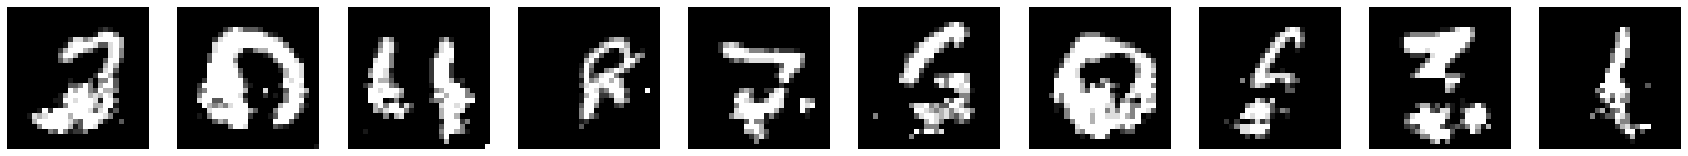

Step 4437, Loss (200 step avg.): 0.31236865864464297


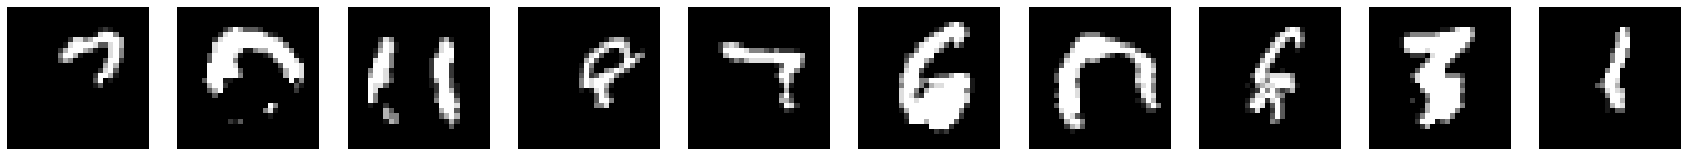

In [ ]:
train(n_epochs, steps_per_epoch, do_eval=True)

In [ ]:
process_batch(test_batch_colors, test_batch_idxs, show_input=True)

In [ ]:
model.save(f'models/{model_name}')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.plot(np.arange(len(loss_history)), loss_history)
ax1.set_title("loss_history")
ax2.plot(np.arange(len(loss_history)), np.log(loss_history))
ax2.set_title("log loss_history")
plt.show()

In [ ]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
])
def eval_step(inp_colors, inp_idxs, tar_idxs):
    return model([inp_colors, inp_idxs, tar_idxs], training=False)
test_batch_colors, test_batch_idxs, batch_labels = next(iter(dataset_test))
test_batch_colors, test_batch_idxs = test_batch_colors[0:10], test_batch_idxs[0:10]
process_batch(test_batch_colors, test_batch_idxs, show_input=True)